* Name: `dissipation-theory--Study-20.ipynb`
* Author: John A. Marohn
* Date: 2024-06-25
* Continued from: `dissipation-theory--Study-17.ipynb` and `dissipation-theory--Study-18.ipynb`
* Continued to: ---
* Summary: Explore how the BLDS signal depends on mobility and charge density.

# Preliminaries

In [200]:
from dissipationtheory.constants import ureg, qe, epsilon0, kb
from dissipationtheory.dissipation import blds_perpendicular_jit
from dissipationtheory.dissipation import CantileverModelJit, SampleModel1Jit
from dissipationtheory.dissipation import theta1norm_jit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import matplotlib.pylab as plt

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [275]:
THIS = 'dissipation-theory--Study-20--'
fig = {}

# Zero-frequency integral

In [259]:
from scipy import integrate

In [260]:
def B(n, theta1, theta2):
    
    def integrand(alpha, n, theta1, theta2):
    
        term1 = np.power(alpha, n) * np.exp(- theta1 * alpha) 
        term2 = (theta2 * np.sqrt(alpha**2 + 1/theta2) - alpha)/ \
                (theta2 * np.sqrt(alpha**2 + 1/theta2) + alpha)

        return term1 * term2
     
    B = np.zeros(len(theta1))
    for index, theta in enumerate(theta1):
        B[index] = np.power(theta, n+1) * \
                    integrate.quad(integrand, 0 , 50/theta, 
                                   args=(n, theta, theta2), epsrel=1e-4)[0]

    return B

In [261]:
theta1 = np.logspace(start=np.log10(5e-2), stop=np.log10(3e3), num=50)

Check that the limiting case is close to 2, as expected from paper-and-pencil work.

In [262]:
 B(2, np.array([1e6]), 1.0)

array([1.999988])

fFr a discussion on setting plotting colors in `matplotlib` see "9 ways to set colors in Matplotlib", Aleksandra Płońska and Piotr Płoński, 2022-11-21, https://mljar.com/blog/matplotlib-colors/.

In [301]:
['default'] + plt.style.available

['default',
 'Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

Crete a plot of the $B^{(2)}(\omega_{\mathrm{m}}=0)$ integral versus the unitless parameter $\theta^2_1$.

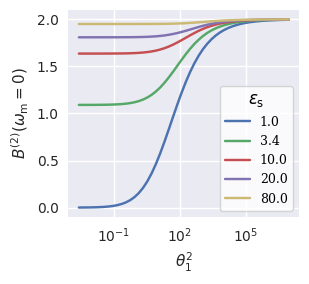

In [304]:
fig['01'] = plt.figure(figsize=(3.25, 3))
for alpha2 in [1.00, 3.4, 10, 20, 80]:
    lbl = "{:0.1f}".format(alpha2)
    with plt.style.context('seaborn-v0_8'):
        plt.semilogx(theta1**2, B(2, theta1, alpha2), label=lbl)
plt.ylabel('$B^{(2)}(\omega_{\mathrm{m}}=0)$')
plt.xlabel('$\\theta_1^2$')
plt.legend(title='$\epsilon_{\mathrm{s}}$', fontsize=9)
plt.tight_layout()
plt.show()

Make a function to generate the plot of $B^{(2)}(\omega_{\mathrm{m}}=0)$ integral versus charge density $\rho$.  Convert the unitless variable $\theta_1^2$ to an equivalent charge density $\rho [1/\mathrm{m}^3]$.  To do the conversion, you need to specify temperature $T$ and tip-sample separation $d$.

In [308]:
def plotB2(theta1, T, d):
    
    rho = (theta1**2 * epsilon0 * kb * T)/(qe**2 * d**2)

    fig = plt.figure(figsize=(3.25, 3))
    for alpha2 in [1.00, 3.4, 10, 20, 80]:
        lbl = "{:0.1f}".format(alpha2)
        with plt.style.context('seaborn-v0_8'):
            plt.semilogx(rho.to('1/cm^3').magnitude, 
                         B(2, theta1, alpha2), label=lbl)
    plt.title('$T$ = {:0.0f} K, d = {:0.0f} nm'.format(
        T.to('K').magnitude,
        d.to('nm').magnitude),
              fontsize=12)
    plt.ylabel('$B^{(2)}(\omega_{\mathrm{m}}=0)$')
    plt.xlabel('$\\rho$ [1/cm$^3$]')
    plt.legend(title='$\epsilon_{\mathrm{s}}$', fontsize=9)
    plt.tight_layout()
    plt.show()
    
    return fig

Pick room temperature and a typical tip-sample separation, 220 nm.

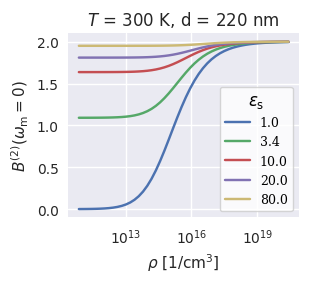

In [309]:
T = ureg.Quantity(300, 'K')
d = ureg.Quantity(220, 'nm')

fig['02a'] = plotB2(theta1, T, d)

Observe that if we move much closer, 22 nm instead of 220 nm, we become sensitive to a larger charge density.

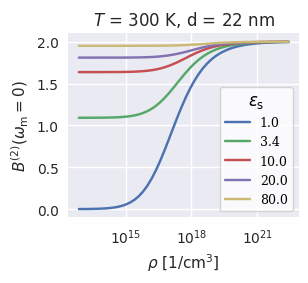

In [310]:
T = ureg.Quantity(300, 'K')
d = ureg.Quantity(22, 'nm')

fig['02b'] = plotB2(theta1, T, d)

# Roll-off frequency

Generate a range of conductivities $\sigma_0$ and compute the associated roll-off frequency $\omega_0 = \sigma_0/\epsilon_0$.

In [312]:
conductivity = ureg.Quantity(np.logspace(start=np.log10(0.9e-10), stop=np.log10(1.1e-4), num=51), 'S/m')

In [313]:
rolloff = (conductivity/epsilon0).to('Hz')

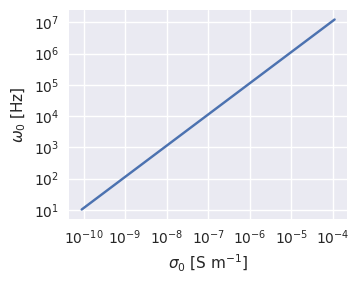

In [317]:
fig['03'] = plt.figure(figsize=(3.75, 3))
with plt.style.context('seaborn-v0_8'):
    plt.loglog(conductivity.to('S/m').magnitude, 
               rolloff.to('Hz').magnitude)
plt.ylabel('$\omega_0$ [Hz]')
plt.xlabel('$\\sigma_0$ [S m$^{-1}$]')
plt.xticks([1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4])
plt.yticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
plt.tight_layout()
plt.show()

# Dissipation versus charge density

Representative numbers from `2024-06-04--jam99--Workup--BLDS-BAPbI3-A-90nm.html` [sic], workup of BLDS signal acquired versus light intensity over BAPI, (butylammonium)$_2$PbI$_4$.

In [290]:
sample1_jit = SampleModel1Jit(
    cantilever = CantileverModelJit(
        f_c = 75e3, 
        V_ts = 1.0,
        R = 30e-9,
        d = 220e-9),
    h_s = 500e-9, 
    epsilon_s = complex(20, 0),
    mu = 1e-10,
    rho = 1e19,
    epsilon_d = complex(1e6, 0),
    z_r = 500e-9
)

Compute the associated conductivity.

In [291]:
sigma = (qe * 
 ureg.Quantity(sample1_jit.mu, 'm^2/(V s)') * 
 ureg.Quantity(sample1_jit.rho, '1/m^3')).to('S/m')

sigma

1.60217663e-10 <Unit('siemens / meter')>

Compute the angular frequency associated with the dielectric constant and the conductivity.

In [292]:
2 * np.pi * ((sigma * sample1_jit.epsilon_s.real) /epsilon0).to('Hz')

2273.9008645309145 <Unit('hertz')>

A range of modulation frequencies going down to very low frequency, so we can see the zero-frequency limit.

In [293]:
omega_m = ureg.Quantity(np.logspace(start=np.log10(1e-2), stop=np.log10(1e8), num=51), 'Hz')
omega_m

Magnitude,[0.01 0.015848931924611134 0.025118864315095794 0.039810717055349734 0.06309573444801933 0.1 0.15848931924611143 0.25118864315095807 0.3981071705534973 0.6309573444801934 1.0 1.584893192461114 2.5118864315095824 3.981071705534973 6.309573444801936 10.0 15.848931924611142 25.11886431509582 39.810717055349734 63.095734448019364 100.0 158.48931924611142 251.18864315095823 398.1071705534977 630.9573444801943 1000.0 1584.893192461114 2511.886431509582 3981.0717055349774 6309.573444801943 10000.0 15848.93192461114 25118.864315095823 39810.71705534977 63095.73444801943 100000.0 158489.3192461114 251188.6431509582 398107.17055349774 630957.3444801943 1000000.0 1584893.1924611174 2511886.4315095823 3981071.7055349695 6309573.444801942 10000000.0 15848931.924611174 25118864.315095823 39810717.05534986 63095734.44801943 100000000.0]
Units,hertz


An array of charge densities, in units of 1/m$^3$, centered around the estimated charge density.

In [294]:
rho = np.logspace(start=np.log10(1e16), stop=np.log10(1e28), num=20)

Now loop.  Running this loop can take a few minutes, depending on how many frequency points and charge-density points you are looping over.

In [295]:
data = {}        # many simulations
data['01'] = {}  # the first simulation
rho_original =  sample1_jit.rho
for rho_ in rho:
    freq = ureg.Quantity(np.zeros_like(omega_m), 'Hz')
    sample1_jit.rho = rho_
    for index, omega_ in enumerate(omega_m):
        freq[index] = blds_perpendicular_jit(theta1norm_jit, sample1_jit, omega_).to('Hz')
    data['01'][str(rho_)] = {'x': omega_m, 'y': freq, 'rho': sample1_jit.rho, 'mu': sample1_jit.mu}
sample1_jit.rho = rho_original

A service function.

In [320]:
def plotme(data, sample_jit):

    fig = plt.figure(figsize=(5,4))
    for key in data.keys():
        
        with plt.style.context('seaborn-v0_8'):
            plt.semilogx(
                data[key]['x'].to('Hz').magnitude,
                np.abs(data[key]['y'].to('Hz').magnitude),
                '-',
                label="{:0.1e}, {:0.1e}".format(data[key]['rho'],data[key]['mu']))

    lbl = '$d = $ {:0.1f} nm, $R = $ {:0.1f} nm'.format(sample_jit.cantilever.d/1e-9, sample_jit.cantilever.R/1e-9)
    plt.title(lbl, fontsize=9)
    plt.legend(title='$\\rho$ [1/m$^3$], $\\mu$ [m$^2$/Vs]', 
               title_fontsize=9, fontsize=8, loc=(1.04, 0), frameon=False)
    plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
    plt.xlabel('mod. frequency $\omega_{\mathrm{m}}$ [rad/s]')
    plt.tight_layout()
    plt.show()
    return fig

Plot the BLDS spectrum for various values of the charge density $\rho$, with the mobility $\mu$ fixed.

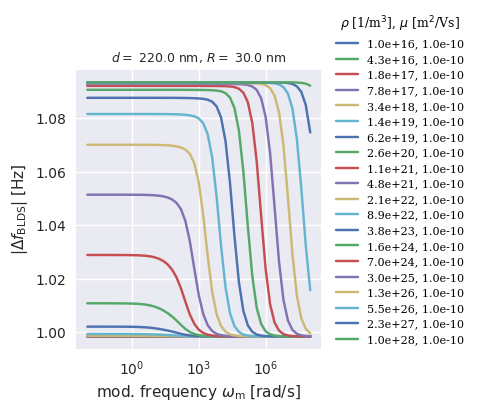

In [321]:
fig['04'] = plotme(data['01'], sample1_jit)

A service function.

In [322]:
def plot_zero_freq_limit_01(sample_jit):
    
    x = np.zeros(len(data['01']))
    y = np.zeros(len(data['01']))
    for index, key in enumerate(data['01']):
        x[index] = ureg.Quantity(float(key),'1/m^3').to('1/cm^3').magnitude
        y[index] = np.abs(data['01'][key]['y'][0].to('Hz').magnitude)

    fig = plt.figure(figsize=(3.25, 4.0))
    with plt.style.context('seaborn-v0_8'):
        plt.semilogx(x, y)
    
    lbl = '$d = $ {:0.1f} nm, $R = $ {:0.1f} nm'.format(
        sample_jit.cantilever.d/1e-9,
        sample_jit.cantilever.R/1e-9)

    plt.title(lbl, fontsize=9)
    plt.xlabel(r'charge density $\rho$ [1/cm$^3$]')
    plt.ylabel('frequency shift |$\Delta f_{\mathrm{BLDS}}(0)$| [Hz]')
    plt.tight_layout()
    plt.show()
    
    return fig

Plot the low-frequency limit of the BLDS frequency shift versus the charge density, with the mobility fixed.

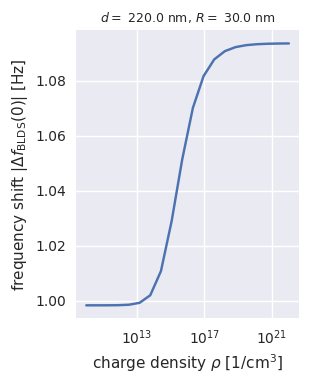

In [323]:
fig['05'] = plot_zero_freq_limit_01(sample1_jit)

We see that the BLDS frequency shift at $\omega_{\mathrm{m}} \rightarrow 0$ follows the $B^{(2)}$ function plotted above.

# Save all figures

In [324]:
for num in fig.keys():
    figname = THIS + "Fig-" + num
    fig[num].savefig(figname + '.png', dpi=300)
    fig[num].savefig(figname + '.pdf')